In [1]:
!python -m pip install pyproj # biblioteca para mudança de sistemas de coordenadas

     |████████████████████████████████| 6.6 MB 4.2 MB/s eta 0:00:01


In [2]:
import matplotlib.pyplot as plt

from datetime import datetime
import json

import numpy as np

from pyproj import Proj, transform

import math

import warnings
warnings.filterwarnings('ignore')

In [3]:
"""
    Vamos carregar os pontos  do cleaned_trajetoBrasil.json na variável pontos_Brasil.
"""

arquivo_pontos = "cleaned_trajetoBrasil.json"

with open(arquivo_pontos, "r") as f:
    pontos_Brasil = f.read()
    pontos_Brasil = json.loads(pontos_Brasil)
    pontos_Brasil = pontos_Brasil['photos']
    
"""
    Vamos carregar os pontos  do cleaned_trajetoBrasil.json na variável pontos_Brasil.
"""
    
arquivo_pontos = "cleaned_trajetoExterior.json"

with open(arquivo_pontos, "r") as f:
    pontos_Exterior = f.read()
    pontos_Exterior = json.loads(pontos_Exterior)
    pontos_Exterior = pontos_Exterior['photos']

In [4]:
"""
Uso opcional.
Aqui escolhemos quais pontos iremos usar no intervalo entre [0-321], no caso do trajeto no Brasil
"""
faixa_de_pontos_Brasil = range(1000,1100)

"""
Uso opcional.
Aqui escolhemos quais pontos iremos usar no intervalo entre [0-225], no caso do trajeto no exterior
"""
faixa_de_pontos_exterior = range(1000,1100)

In [5]:
"""
 Função que calcula em metros a distância entre dois pontos p1 e p2, com latitudes lat_p1 e lat_p2 
 e longitudes long_p1 e long_p2, respectivamente. Usa a fórmula de haversine.
"""

def haversine(points_object, index_p1, index_p2): 
    r = 6371000
    lat_p1 = float(points_object[index_p1]['lat'])
    lat_p2 = float(points_object[index_p2]['lat'])
    long_p1 = float(points_object[index_p1]['lng'])
    long_p2 = float(points_object[index_p2]['lng'])
    
    d = 2*r*math.asin(math.sqrt((math.sin((lat_p2 - lat_p1)/2))**2 + math.cos(lat_p1)*math.cos(lat_p2)*(math.sin( (long_p2 - long_p1)/2 ))**2))
    return d

In [6]:
"""
# Função que calcula em metros a distância entre dois pontos p1 e p2, com latitudes lat_p1 e lat_p2
# e longitudes long_p1 e long_p2, respectivamente. Usa a fórmula de trigonometria esférica.
"""

def trogonometriaEsferica(points_object, index_p1, index_p2):
    r = 6371000
    lat_p1 = float(points_object[index_p1]['lat'])
    lat_p2 = float(points_object[index_p2]['lat'])
    long_p1 = float(points_object[index_p1]['lng'])
    long_p2 = float(points_object[index_p2]['lng'])
    
    C = math.sin(lat_p1)*math.sin(lat_p2) + math.cos(long_p2 - long_p1)*math.cos(lat_p1)*math.cos(lat_p2)
    d = (r*math.pi*math.acos(C))/180
    return d

In [7]:

 """
    Essa função recebe um índice numérico correspondendo 
    a uma posição na lista de pontos "points_object".
    
    Usa os pontos na projeção EPSG:3857 em
    que a unidade de medida é em metros e portanto
    podemos calcular a distância euclidiana entre dois
    pontos com base em suas coordenadas.
    
    Os pontos retornados são um vetor numpy em que
    a primeira posição é uma medida em metros no eixo
    horizontal e a segunda é num eixo vertical.
    """
    
def get_point_coords_proj(index, points_object):
    lat = points_object[index]['lat']
    lat = float(lat)
    lng = points_object[index]['lng']
    lng = float(lng)
    p = np.array((lng, lat))
    p = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), p[0], p[1])
    return p

"""
    Tendo como parâmetros os vetores numpy 2D 'v1' e 'v2', crie uma
    função que retorne a distância euclidiana entre os dois vetores.
"""
    
def distancia_euclidiana(v1, v2):
    distancia = ((v1[0] - v2[0])**2 + (v1[1] - v2[1])**2)**(1/2)
    return distancia



In [8]:
"""
    Retorna a data e hora em que o ponto 'index',
    da lista de pontos 'points_object', foi criado.
    
    O formato de retorno é uma string '%Y-%m-%d %H:%M:%S'
    (e.g. 2018-03-03 20:55:32)
"""
    
FMT = '%Y-%m-%d %H:%M:%S'
def get_shot_time(index, points_object):
    t = points_object[index]['shot_date']
    t = datetime.strptime(t, FMT)
    return t

"""
    Retorna lista com os pontos da lista points_object que estão entre o intervalo ]min_sex, max_sex[
"""

def get_points_in_time_interval(min_sec, max_sec, points_object):
    selected_points = []
    for i in range(len(points_object)):
        point = points_object[i]
        if point['tempo_decorrido'] < min_sec:
            continue
        if point['tempo_decorrido'] > max_sec:
            break
        selected_points.append(point)
    return selected_points

In [9]:
"""
    A projeção de coordenadas esféricas para o plano cartesiano é uma operação computacionalmente demorada.
    Assim, executamos previamente a projeção das coordenadas do sistema de coordenadas EPSG:4326 (coordenadas esféricas) 
    para o sistema de coordenadas EPSG:3857 (com coordenadas no plano cartesiano e unidades em metros). As coordenadas 
    convertidas foram armazenadas no próprio arquivo json com os pontos de cada foto. As novas propriedades se chamam 
    easting indicando em metros a posição da foto no eixo horizontal e northing indicando também em metros a posição 
    da foto no eixo vertical.
""" 


"""
    Adiciona as chaves 'easting' e 'northing' com seus respectivos valores
    no pontos_Brasil e escreve no arquivo cleaned_trajetoBrasil2.json
"""

for i in range(len(pontos_Brasil)):
    if pontos_Brasil[i].get('easting') is not None:
        continue
    easting, northing = get_point_coords_proj(i, pontos_Brasil)
    pontos_Brasil[i]['easting'] = easting
    pontos_Brasil[i]['northing'] = northing

with open('cleaned_trajetoBrasil2.json', 'w+') as f:
    json.dump(pontos_Brasil, f, indent=2)


In [12]:
"""
    Adiciona as chaves 'easting' e 'northing' com seus respectivos valores
    no pontos_Exterior e escreve no arquivo cleaned_trajetoExterior2.json
"""


for i in range(len(pontos_Exterior)):
    if pontos_Exterior[i].get('easting') is not None:
        continue
    easting, northing = get_point_coords_proj(i, pontos_Exterior)
    pontos_Exterior[i]['easting'] = easting
    pontos_Exterior[i]['northing'] = northing

with open('cleaned_trajetoExterior2.json', 'w+') as f:
    json.dump(pontos_Exterior, f, indent=2)

In [19]:
"""
    Calcula o tempo decorrido entre dois pontos da lista points_object
"""

def tempo_decorrido(points_object, index1, index2):
    tdelta = get_shot_time(index2, points_object)-get_shot_time(index1, points_object)
    tdelta = tdelta.seconds
    return tdelta

In [20]:
"""
    Calcula a distância percorrida entre dois pontos da lista points_object usando projeção de Mercator
"""
def distancia_percorrida_Mercator(points_object, index1, index2):
    p1 = np.array((points_object[index1]['easting'], points_object[index1]['northing']))
    p2 = np.array((points_object[index2]['easting'], points_object[index2]['northing']))
    dist = distancia_euclidiana(p1, p2)
    return dist

"""
    Calcula a distância percorrida entre dois pontos da lista points_object usando a fórmula de Haversine
"""
def distancia_percorrida_Haversine(points_object, index1, index2):
    return haversine(points_object, index1, index2)

"""
    Calcula a distância percorrida entre dois pontos da lista points_object usando a fórmula da trigonometria esférica
"""
def distancia_percorrida_Trigonometria(points_object, index1, index2):
    return trogonometriaEsferica(points_object, index1, index2)

In [21]:
"""
    Insere os valores calculados como novas propriedades dos pontos chamadas distancia_mercator, 
    distancia_haversine, distancia_trigonometria e tempo_decorrido (em segundos) 
"""

def coleção(points_object):
    
    points_object[0]['distancia_mercator'] = 0
    points_object[0]['distancia_haversine'] = 0
    points_object[0]['distancia_trigonometria'] = 0
    points_object[0]['tempo_decorrido'] = 0
    
    for i in range(0, len(points_object)-1):
        
        tempo = tempo_decorrido(points_object, i, i+1)
        dist_mercator = distancia_percorrida_Mercator(points_object, i, i+1)
        dist_haversine = distancia_percorrida_Haversine(points_object, i, i+1)
        dist_trigonometria = distancia_percorrida_Trigonometria(points_object, i, i+1)
        
        points_object[i+1]['tempo_decorrido'] = points_object[i]['tempo_decorrido'] + tempo
        points_object[i+1]['distancia_mercator'] = points_object[i]['distancia_mercator'] + dist_mercator
        points_object[i+1]['distancia_haversine'] = points_object[i]['distancia_haversine'] + dist_haversine
        points_object[i+1]['distancia_trigonometria'] = points_object[i]['distancia_trigonometria'] + dist_trigonometria
        
    return points_object

"""
    Salva a nova coleção de pontos num novo arquivo json chamado cleaned_trajetoBrasil3.json.
"""
f = open("cleaned_trajetoBrasil3.json", "w")
f.write(json.dumps(coleção(pontos_Brasil)))

"""
    Salva a nova coleção de pontos num novo arquivo json chamado cleaned_trajetoExterior3.json.
"""
f = open("cleaned_trajetoExterior3.json", "w")
f.write(json.dumps(coleção(pontos_Exterior)))

863784

In [22]:
"""
    No trajeto no exterior:
    
    tempos_Exterior - vetor com a lista dos tempo em que cada ponto foi alcançado
    
    distancias_mercator_Exterior - vetor com a lista das distâncias acumuladas em cada trecho 
    (entre cada um ponto e outro) usando a projeção de Mercator.
    
    distancias_haversine_Exterior - vetor com a lista das distâncias acumuladas em cada trecho 
    (entre cada um ponto e outro) usando a fórmula de haversine. 
    
    distancias_trigonometria_Exterior - vetor com a lista das distâncias acumuladas em cada trecho 
    (entre cada um ponto e outro) usando a fórmula de trigonometria esférica.
    
    velocidades_mercator_Exterior - vetor com a lista de velocidades médias em cada trecho, usando 
    o vetor distancias_mercator_Exterior
    
    velocidades_haversine_Exterior - vetor com a lista de velocidades médias em cada trecho, usando 
    o vetor distancias_haversine_Exterior
    
    velocidades_trigonometria_Exterior - vetor com a lista de velocidades médias em cada trecho, usando 
    o vetor distancias_trigonometrica_Exterior
"""

tempos_Exterior = []
distancias_mercator_Exterior = []
distancias_haversine_Exterior = []
distancias_trigonometria_Exterior = []

tempos_Exterior = [pontos_Exterior[i]['tempo_decorrido'] for i in range(0, len(pontos_Exterior))]
distancias_mercator_Exterior = [pontos_Exterior[i]['distancia_mercator'] for i in range(0, len(pontos_Exterior))]
distancias_haversine_Exterior = [pontos_Exterior[i]['distancia_haversine'] for i in range(0, len(pontos_Exterior))]
distancias_trigonometria_Exterior = [pontos_Exterior[i]['distancia_trigonometria'] for i in range(0, len(pontos_Exterior))]

velocidades_mercator_Exterior = []
velocidades_mercator_Exterior.append(0)
velocidades_haversine_Exterior = []
velocidades_haversine_Exterior.append(0)
velocidades_trigonometria_Exterior = []
velocidades_trigonometria_Exterior.append(0)

for i in range(0, len(pontos_Exterior)-1):
    delta_t = pontos_Exterior[i+1]['tempo_decorrido'] - pontos_Exterior[i]['tempo_decorrido']

    delta_s_mercator = pontos_Exterior[i+1]['distancia_mercator'] - pontos_Exterior[i]['distancia_mercator']
    delta_s_haversine = pontos_Exterior[i+1]['distancia_haversine'] - pontos_Exterior[i]['distancia_haversine']
    delta_s_trigonometria = pontos_Exterior[i+1]['distancia_trigonometria'] - pontos_Exterior[i]['distancia_trigonometria']
    
    vm_mercator =  delta_s_mercator/delta_t
    velocidades_mercator_Exterior.append(vm_mercator)
    
    vm_haversine =  delta_s_haversine/delta_t
    velocidades_haversine_Exterior.append(vm_haversine)
    
    vm_trigonometria =  delta_s_trigonometria/delta_t
    velocidades_trigonometria_Exterior.append(vm_trigonometria)

In [23]:
"""
    O código abaixo serve para você visualizar a posição do carro em função do tempo.
"""
def plot_dist_time(dist_vec, time_vec, marker='.', **kwargs):
    fig, ax = plt.subplots(1, **kwargs)
    #fig, ax = plt.subplots(1, figsize=(16,8))
    ax.scatter(time_vec, dist_vec, marker=marker)
    ax.set_xlabel('tempo decorrido (s)', fontsize=14);
    ax.set_ylabel('distância percorrida (m)', fontsize=14);
    return fig, ax


"""
    O código abaixo serve para você visualizar as velocidades médias calculadas em função do tempo.
"""
def plot_vel_time(vel_vec, time_vec, marker='.', **kwargs):
    fig, ax = plt.subplots(1, **kwargs)
    #fig, ax = plt.subplots(1, figsize=(16,8))
    ax.scatter(time_vec, vel_vec, marker=marker)
    ax.set_xlabel('tempo decorrido (s)', fontsize=14);
    ax.set_ylabel('velocidade (m/s)', fontsize=14);
    return fig, ax

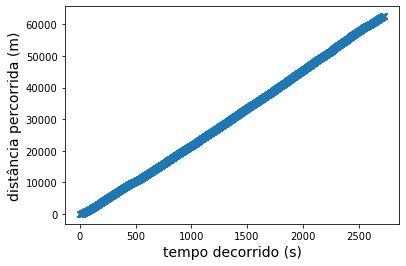

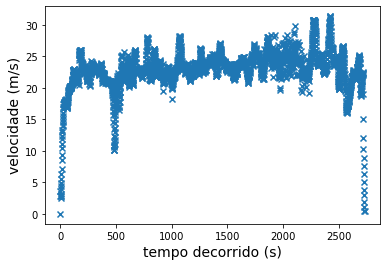

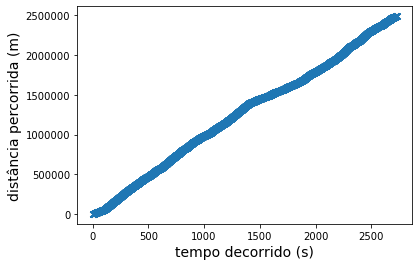

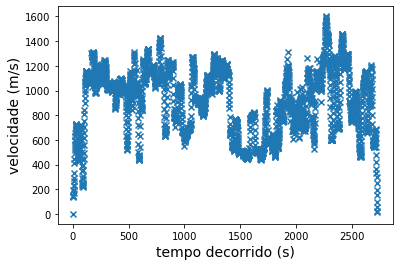

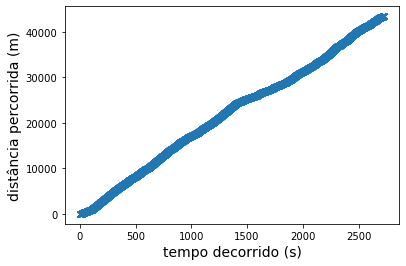

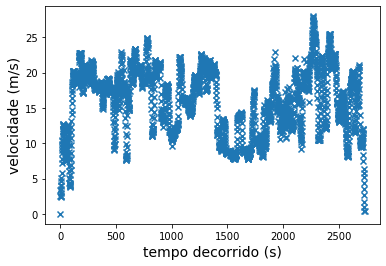

In [24]:
"""
    Gráficos de distância por tempo e velocidade média por tempo do trajeto no Exterior 
"""

# Distância calculada usando a projeção de Mercator
fig, ax = plot_dist_time(distancias_mercator_Exterior, tempos_Exterior, marker='x')

# Velocidade média calculada usando a projeção de Mercator
fig, ax = plot_vel_time(velocidades_mercator_Exterior, tempos_Exterior, marker='x')

# Distância calculada usando a fórmula de Haversine
fig, ax = plot_dist_time(distancias_haversine_Exterior, tempos_Exterior, marker='x')

# Velocidade média calculada usando a fórmula de Haversine
fig, ax = plot_vel_time(velocidades_haversine_Exterior, tempos_Exterior, marker='x')

# Distância calculada usando a fórmula de trigonometria esférica
fig, ax = plot_dist_time(distancias_trigonometria_Exterior, tempos_Exterior, marker='x')

# Velocidade média calculada usando a fórmula de trigonometria esférica
fig, ax = plot_vel_time(velocidades_trigonometria_Exterior, tempos_Exterior, marker='x')